# Week 6: Computer Vision I — CNN Fundamentals
## COMP 9130 — Applied Artificial Intelligence

*Group:* 8

*Names:* Binger Yu & Savina Cai

*Date:* Feb. 12, 2026

---

**Today's Dataset:** Wildfire Detection Image Data (~1,900 images, binary: fire vs no-fire)

**Learning Objectives:**
1. Build a CNN from scratch using Conv2D and pooling layers
2. Train a CNN for binary image classification (wildfire detection)
3. Use Keras augmentation layers to reduce overfitting
4. Visualize CNN internals — feature maps and learned filters

**Today's Tasks:**
| Time | Task | Points |
|------|------|--------|
| 0:00–0:20 | Quiz 5 | 5 pts |
| 0:30–1:20 | Task 1: Build & Train a Basic CNN | 5 pts |
| 1:30–2:20 | Task 2: Data Augmentation | 5 pts |
| 2:20–2:55 | Task 3: Visualize CNN Internals | 5 pts |

**Pair Programming Reminder:** One person types, one person thinks. Switch roles between tasks!

---

## Setup & Imports

Run this cell first. Make sure you have GPU enabled: **Runtime → Change runtime type → T4 GPU**

In [ ]:
# ============================================================
# SETUP — Run this first!
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.19.0
NumPy version:      2.0.2

✅ GPU available: /physical_device:GPU:0


## Download & Load the Wildfire Dataset

We're using a real wildfire detection dataset from Kaggle: ~1,900 images of fire/no-fire scenes.

In [ ]:
# Download the dataset
!pip install -q kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("brsdincer/wildfire-detection-image-data")
print(f"Dataset downloaded to: {dataset_path}")

# Print structure to understand folder layout
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if level >= 3:
        continue

# Find the directory with exactly 2 class subfolders containing images
data_dir = None
for root, dirs, files in os.walk(dataset_path):
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    if len(dirs) == 2:
        has_images = False
        for d in dirs:
            subpath = os.path.join(root, d)
            img_files = [f for f in os.listdir(subpath)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if len(img_files) > 10:
                has_images = True
                break
        if has_images:
            data_dir = root
            break

if data_dir is None:
    raise FileNotFoundError("Could not find class folders. Check the structure above.")

print(f"\n✅ Data directory: {data_dir}")
for d in sorted(os.listdir(data_dir)):
    sub = os.path.join(data_dir, d)
    if os.path.isdir(sub):
        n = len([f for f in os.listdir(sub) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"   - {d}: {n} images")

100%|██████████| 24.9M/24.9M [00:00<00:00, 166MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/brsdincer/wildfire-detection-image-data/versions/1

Dataset structure:
1/  (0 files)
  forest_fire/  (0 files)
    Training and Validation/  (0 files)
      fire/  (928 files)
      nofire/  (904 files)
    Testing/  (0 files)
      fire/  (22 files)
      nofire/  (46 files)

✅ Data directory: /root/.cache/kagglehub/datasets/brsdincer/wildfire-detection-image-data/versions/1/forest_fire/Training and Validation
   - fire: 928 images
   - nofire: 904 images


In [ ]:
# Load images into TensorFlow datasets
IMG_SIZE = 250  # Original resolution (250x250)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 1832 files belonging to 2 classes.
Using 1466 files for training.
Found 1832 files belonging to 2 classes.
Using 366 files for validation.
Class names: ['fire', 'nofire']


## Explore the Data

Let's see what our images look like and understand their properties.

In [ ]:
# Count images per class
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    n_images = len([f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"  {class_name}: {n_images} images")

  fire: 928 images
  nofire: 904 images


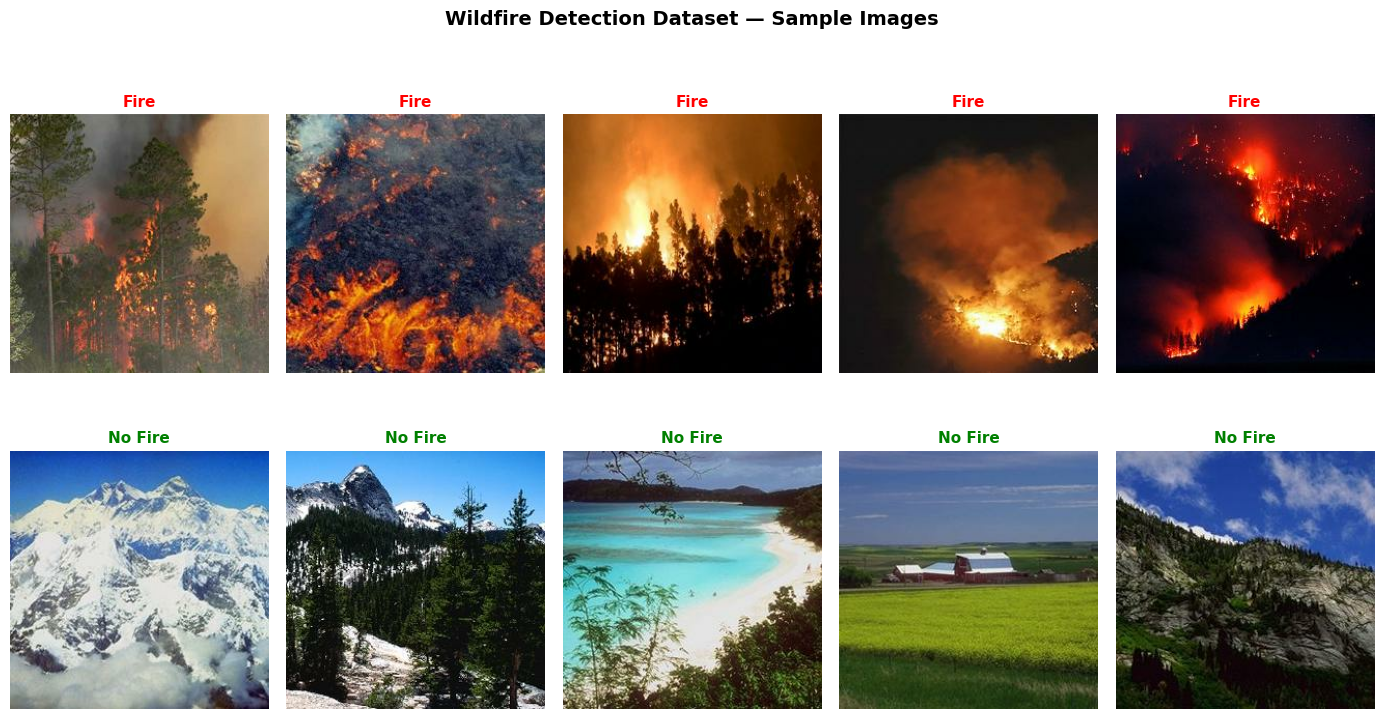

In [ ]:
# Visualize sample images from both classes
plt.figure(figsize=(14, 8))

# Keras assigns classes alphabetically: fire=0, nofire=1
fire_class = class_names.index('fire') if 'fire' in class_names else 0
nofire_class = 1 - fire_class

for images, labels in train_ds.take(1):
    fire_mask = labels.numpy().flatten() == fire_class
    nofire_mask = labels.numpy().flatten() == nofire_class

    # Show fire images (top row)
    fire_images = images[fire_mask]
    for i in range(min(5, len(fire_images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(fire_images[i].numpy().astype('uint8'))
        plt.title('Fire', fontsize=11, fontweight='bold', color='red')
        plt.axis('off')

    # Show no-fire images (bottom row)
    nofire_images = images[nofire_mask]
    for i in range(min(5, len(nofire_images))):
        plt.subplot(2, 5, i + 6)
        plt.imshow(nofire_images[i].numpy().astype('uint8'))
        plt.title('No Fire', fontsize=11, fontweight='bold', color='green')
        plt.axis('off')

plt.suptitle('Wildfire Detection Dataset — Sample Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Inspect image properties
for images, labels in train_ds.take(1):
    print(f"Batch shape:  {images.shape}")
    print(f"Label shape:  {labels.shape}")
    print(f"Pixel range:  [{images.numpy().min():.0f}, {images.numpy().max():.0f}]")
    print(f"\nSingle image shape: {images[0].shape}")
    print(f"  → Height: {images[0].shape[0]}, Width: {images[0].shape[1]}, Channels: {images[0].shape[2]}")

# Why CNNs?
print(f"\n💡 If we flattened this image: {250*250*3:,} input features!")
print(f"   Compare to MNIST flattened: {28*28} input features")
print(f"   → This is why CNNs use weight sharing through convolutions!")

Batch shape:  (32, 250, 250, 3)
Label shape:  (32, 1)
Pixel range:  [0, 255]

Single image shape: (250, 250, 3)
  → Height: 250, Width: 250, Channels: 3

💡 If we flattened this image: 187,500 input features!
   Compare to MNIST flattened: 784 input features
   → This is why CNNs use weight sharing through convolutions!


In [ ]:
# Optimize data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Data pipeline optimized")

✅ Data pipeline optimized


In [ ]:
# ============================================================
# PROVIDED: Helper function for plotting training curves
# (You'll use this in Tasks 1 and 2)
# ============================================================

def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    print(f"\n📊 Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   ⚠️  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   ⚡ Moderate gap — some overfitting")
    else:
        print(f"   ✅ Small gap — good generalization!")


def show_predictions(model, dataset, class_names, n=10):
    """Show model predictions on sample images."""
    plt.figure(figsize=(16, 4))
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        for i in range(min(n, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            pred_prob = predictions[i][0]
            pred_label = 1 if pred_prob > 0.5 else 0
            true_label = int(labels[i].numpy())
            color = 'green' if pred_label == true_label else 'red'
            plt.title(f'Pred: {class_names[pred_label]}\n({pred_prob:.2f})\nTrue: {class_names[true_label]}',
                     fontsize=9, color=color, fontweight='bold')
            plt.axis('off')
    plt.suptitle('Predictions (Green=Correct, Red=Wrong)', fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Helper functions loaded")

✅ Helper functions loaded


---

# ═══════════════════════════════════════════
# TASK 1: Build & Train a Basic CNN (50 min)
# ═══════════════════════════════════════════

Build your first Convolutional Neural Network for wildfire detection!

**Architecture to build:**
```
Input (250×250×3) → Rescaling (0-1)
  → Conv2D(32, 3×3, relu) → MaxPool(2×2)
  → Conv2D(64, 3×3, relu) → MaxPool(2×2)
  → Conv2D(128, 3×3, relu) → MaxPool(2×2)
  → Flatten → Dense(128, relu) → Dense(1, sigmoid)
```

**Key concepts:**
- `Rescaling(1./255)`: Normalizes pixels from [0, 255] to [0, 1]
- `Conv2D(filters, kernel_size, activation)`: Applies learned filters to detect patterns
- `MaxPooling2D(pool_size)`: Reduces spatial dimensions by keeping max values
- `Flatten`: Converts 3D feature maps to 1D for the Dense layers
- `Dense(1, sigmoid)`: Outputs probability of fire (binary classification)

In [ ]:
# ============================================================
# TODO: Build your CNN model
# ============================================================
# Follow the architecture diagram above.
# Hint: Use models.Sequential([...]) with the layers listed.

model_basic = models.Sequential([
    # TODO: Add Rescaling layer (normalize pixels to 0-1)
    #       Don't forget input_shape=(IMG_SIZE, IMG_SIZE, 3)
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # TODO: Conv Block 1 — Conv2D(32 filters, 3x3, relu) + MaxPooling2D(2x2)
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),

    # TODO: Conv Block 2 — Conv2D(64 filters, 3x3, relu) + MaxPooling2D(2x2)
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),

    # TODO: Conv Block 3 — Conv2D(128 filters, 3x3, relu) + MaxPooling2D(2x2)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # TODO: Flatten → Dense(128, relu)
    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # TODO: Classification head — Flatten, Dense(128, relu), Dense(1, sigmoid)
    layers.Dense(1, activation='sigmoid')

])

# Display the architecture
model_basic.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,449 (52.92 MB)

 Trainable params: 13,872,449 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================================
# TODO: Compile the model
# ============================================================
# Use:
#   optimizer = 'adam'
#   loss = 'binary_crossentropy' (because binary classification)
#   metrics = ['accuracy']

# YOUR CODE HERE
model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# ============================================================
# TODO: Train the model for 50 epochs
# ============================================================
# Use model_basic.fit() with:
#   - train_ds as training data
#   - val_ds as validation_data
#   - epochs=15
# Save the result to history_basic

EPOCHS = 50

# YOUR CODE HERE
history_basic = model_basic.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.7914 - loss: 0.4421 - val_accuracy: 0.9454 - val_loss: 0.2138
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9494 - loss: 0.1623 - val_accuracy: 0.9454 - val_loss: 0.2210
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9592 - loss: 0.1416 - val_accuracy: 0.9481 - val_loss: 0.2080
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9614 - loss: 0.1263 - val_accuracy: 0.9372 - val_loss: 0.1889
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9695 - loss: 0.0997 - val_accuracy: 0.9372 - val_loss: 0.2386
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9790 - loss: 0.0902 - val_accuracy: 0.9481 - val_loss: 0.2346
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9782 - loss: 0.0646 - val_accuracy: 0.9481 - val_loss: 0.2503
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9768 - loss: 0.0552 - val_accuracy: 0.9399 -

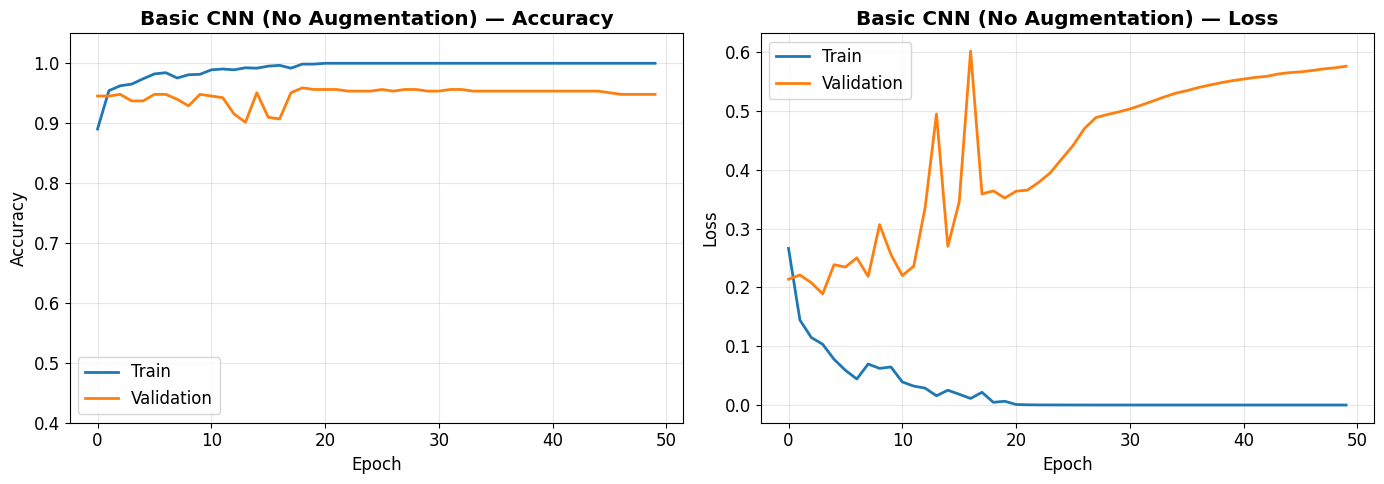


📊 Final Results:
   Train Accuracy:      1.0000 (100.0%)
   Validation Accuracy: 0.9481 (94.8%)
   Gap (overfit check): 0.0519 (5.2%)
   ⚡ Moderate gap — some overfitting


In [ ]:
# Plot training curves (use the provided helper function)
plot_training_curves(history_basic, title='Basic CNN (No Augmentation)')

/tmp/ipython-input-3856226649.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[i].numpy())


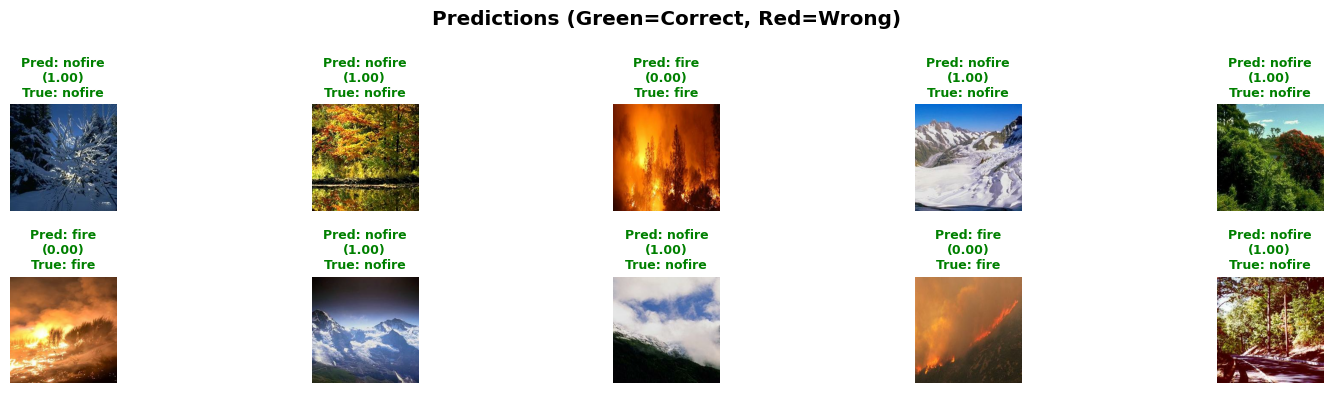

In [ ]:
# Show predictions on validation images
show_predictions(model_basic, val_ds, class_names)

## ✅ Task 1 Checkpoint — Show your instructor

| Criteria | Points |
|----------|--------|
| CNN built, trained, ≥75% val accuracy, analysis answered | 5 pts |
| CNN trains but accuracy <75% or incomplete analysis | 3 pts |
| Attempted but doesn't train properly | 1 pt |

### 📝 Task 1 Analysis Questions

**Answer using YOUR specific results (numbers from YOUR training).**

**Q1:** What is your model's final training accuracy and validation accuracy? Is the model overfitting? How can you tell from the training curves?

Based on my specific results, the model finished with a Final Train Accuracy of 100% (10000) and a Validation Accuracy of 94.*% (0.9481).

Yes, the model is definitely showing signs of overfitting. I can tell this by looking at two things in the training curves:

1. The Gap: There is a 5.2% gap between the training adn validation accuracy. While the model perfectly "memorized" the training set, it struggled slightly more with the unseen validation data.
2. The Loss Divergence: In the Loss plot, the Train loss drops smoothly to almost zero, but the Validation loss starts to climb steadily after about epoch 15. This upward trend in validation loss while training loss continues to fall is the clasic "smoking gun" for overfitting - the model is getting overconfident in its training-specific patterns.


**Q2:** Look at the `model.summary()` output. Which layer has the most parameters? Why does the Flatten → Dense connection create so many parameters?

The layer with the most parameters is the first Dense layer (immediately following the Flatten layer).

The reason this connection creates such a massive number of parameters is because of the "All-to-All" connectivity. After the final convolutional block, the Flatten layer takes the 3D feature maps and unrolls them into one very long 1D vector. Every single one of those thousands of "unrolled" features must then be connected to every one of the 128 neurons in the Dense layer. Since each connection represents a unique weight the model has to learn, the math ($inputs \times neurons$) leads to a parameter explosion compared to the much smaller, shared weights used in the convolutional layers.

**Q3:** Why do we increase the number of filters (32 → 64 → 128) as we go deeper? What happens to the spatial dimensions at the same time?

We increase the number of filters as we go deeper to allow the model to learn increasingly complex and abstract features. The early layers (32 filters) focus on simple things like edges or color gradients, but deeper layers (128 filters) combine those simple shapes into complex textures or specific objects like smoke plumes or tree patterns.

At the same time, the spatial dimensions (height and width) are decreasing because of the Max Pooling layers. As the "where" information (spatial resolution) gets smaller and more compressed, we increase the "what" information (the number of filters) to ensure the model has enough capacity to represent the rich variety of features it's discovering.


---

# ══════════════════════════════════════════════
# TASK 2: Data Augmentation (50 min)
# ══════════════════════════════════════════════

Your Task 1 model likely overfits (training accuracy >> validation accuracy). Let's fix that with **data augmentation** — applying random transforms to training images so the model sees different versions each epoch.

We'll use modern **Keras augmentation layers** that integrate directly into the model.

## Part 2A: Visualize What Augmentation Does

In [ ]:
# ============================================================
# Define augmentation layers
# ============================================================
# These layers apply random transformations during training ONLY.
# During prediction, they automatically deactivate.

data_augmentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name='data_augmentation')

print("Augmentation layers:")
for layer in data_augmentation.layers:
    print(f"  - {layer.__class__.__name__}")

Augmentation layers:
  - RandomFlip
  - RandomRotation
  - RandomZoom
  - RandomContrast


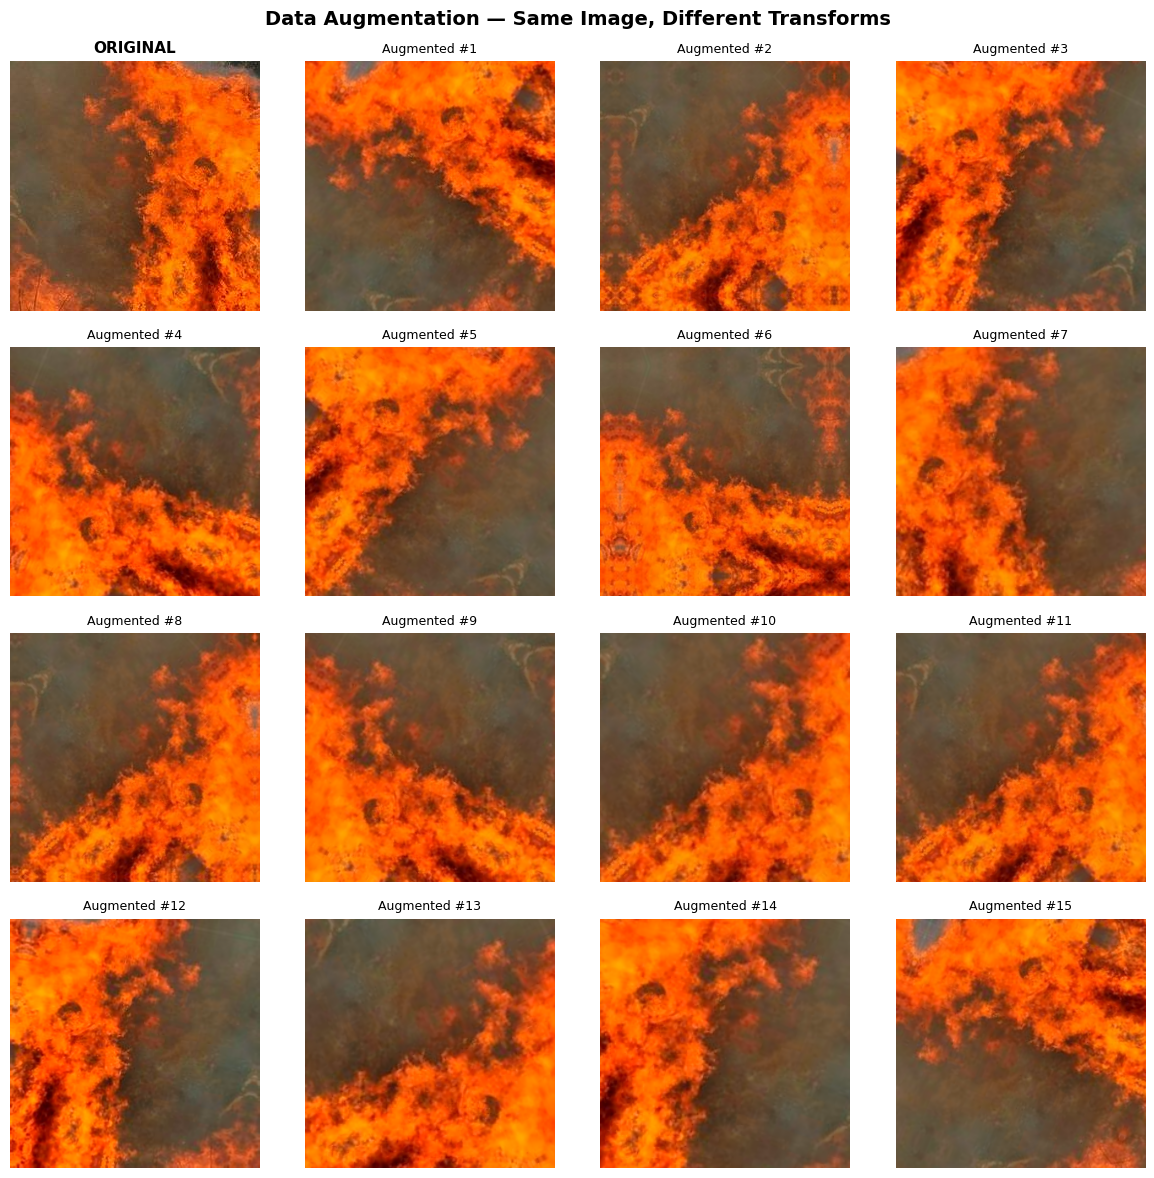

💡 Each epoch, the model sees a DIFFERENT version of every training image.


In [ ]:
# Visualize augmentation on a single image
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    sample_image = images[0]

    plt.subplot(4, 4, 1)
    plt.imshow(sample_image.numpy().astype('uint8'))
    plt.title('ORIGINAL', fontweight='bold', fontsize=11)
    plt.axis('off')

    for i in range(15):
        augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
        plt.subplot(4, 4, i + 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(f'Augmented #{i+1}', fontsize=9)
        plt.axis('off')

plt.suptitle('Data Augmentation — Same Image, Different Transforms', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Each epoch, the model sees a DIFFERENT version of every training image.")

## Part 2B: Build CNN with Augmentation + Dropout

In [ ]:
# ============================================================
# TODO: Build a CNN with augmentation layers built in
# ============================================================
# Same CNN architecture as Task 1, BUT:
#   1. Add augmentation layers AFTER Rescaling (before Conv layers)
#   2. Add Dropout(0.3) AFTER Flatten (before Dense)
#   3. #
# Architecture:
#   Rescaling → RandomFlip → RandomRotation → RandomZoom → RandomContrast
#   → Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Conv2D(128) → MaxPool
#   → Flatten → Dropout(0.3) → Dense(128, relu) → Dense(1, sigmoid)

model_augmented = models.Sequential([
    # TODO: Rescaling layer with input_shape
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # TODO: Add the 4 augmentation layers
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),

    # TODO: Same 3 Conv+Pool blocks as Task 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # TODO: Flatten → Dropout(0.3) → Dense(128, relu) → Dense(1, sigmoid)
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

model_augmented.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 250, 250, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 250, 250, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,449 (52.92 MB)

 Trainable params: 13,872,449 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================================
# TODO: Compile and train the augmented model
# ============================================================
# Same compile settings as Task 1
# Train for 50 epochs (same as basic) (same as basic for fair comparison)

EPOCHS_AUG = 50

# YOUR CODE HERE
model_augmented.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_augmented = model_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_AUG
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6107 - loss: 1.3194 - val_accuracy: 0.8661 - val_loss: 0.5122
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9146 - loss: 0.3710 - val_accuracy: 0.9208 - val_loss: 0.2406
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9391 - loss: 0.1796 - val_accuracy: 0.9508 - val_loss: 0.2032
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9528 - loss: 0.1572 - val_accuracy: 0.9235 - val_loss: 0.2464
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9396 - loss: 0.1815 - val_accuracy: 0.9372 - val_loss: 0.2521
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9563 - loss: 0.1545 - val_accuracy: 0.9208 - val_loss: 0.2970
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9312 - loss: 0.1854 - val_accuracy: 0.9153 - val_loss: 0.3161
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9401 - loss: 0.1801 - val_accuracy: 0.9344 - 

## Part 2C: Compare Results

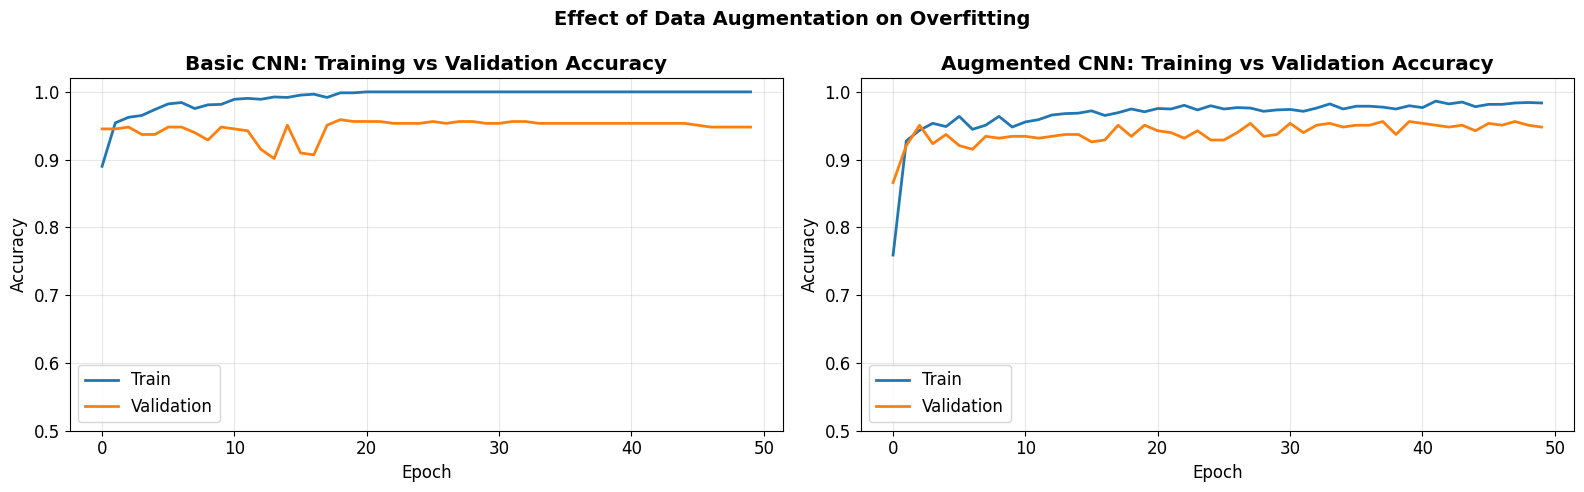

In [ ]:
# ============================================================
# TODO: Plot both models' training curves side by side
# ============================================================
# Create a figure with 2 subplots (1 row, 2 columns)
# Left: Basic CNN accuracy curves (train + val)
# Right: Augmented CNN accuracy curves (train + val)
#
# Hint: Use history_basic.history['accuracy'] and
#       history_augmented.history['accuracy']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# YOUR CODE HERE — plot train/val accuracy for both models
# Left Plot: Basic CNN (from Task 1)
axes[0].plot(history_basic.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_basic.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Basic CNN: Training vs Validation Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.02]) # Set scale to see the gap clearly

# Right Plot: Augmented CNN (from Task 2)
axes[1].plot(history_augmented.history['accuracy'], label='Train', linewidth=2)
axes[1].plot(history_augmented.history['val_accuracy'], label='Validation', linewidth=2)
axes[1].set_title('Augmented CNN: Training vs Validation Accuracy', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.5, 1.02]) # Keep scale consistent for fair comparison

plt.suptitle('Effect of Data Augmentation on Overfitting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# TODO: Create a comparison table
# ============================================================
# Fill in your actual numbers from training

import pandas as pd

basic_train = history_basic.history['accuracy'][-1]
basic_val = history_basic.history['val_accuracy'][-1]
aug_train = history_augmented.history['accuracy'][-1]
aug_val = history_augmented.history['val_accuracy'][-1]

comparison = pd.DataFrame({
    'Model': ['Basic CNN', 'Augmented CNN'],
    'Train Acc': [f'{basic_train:.4f}', f'{aug_train:.4f}'],
    'Val Acc': [f'{basic_val:.4f}', f'{aug_val:.4f}'],
    'Gap': [f'{basic_train - basic_val:.4f}', f'{aug_train - aug_val:.4f}']
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


MODEL COMPARISON
        Model Train Acc Val Acc    Gap
    Basic CNN    1.0000  0.9481 0.0519
Augmented CNN    0.9836  0.9481 0.0355


/tmp/ipython-input-3856226649.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[i].numpy())


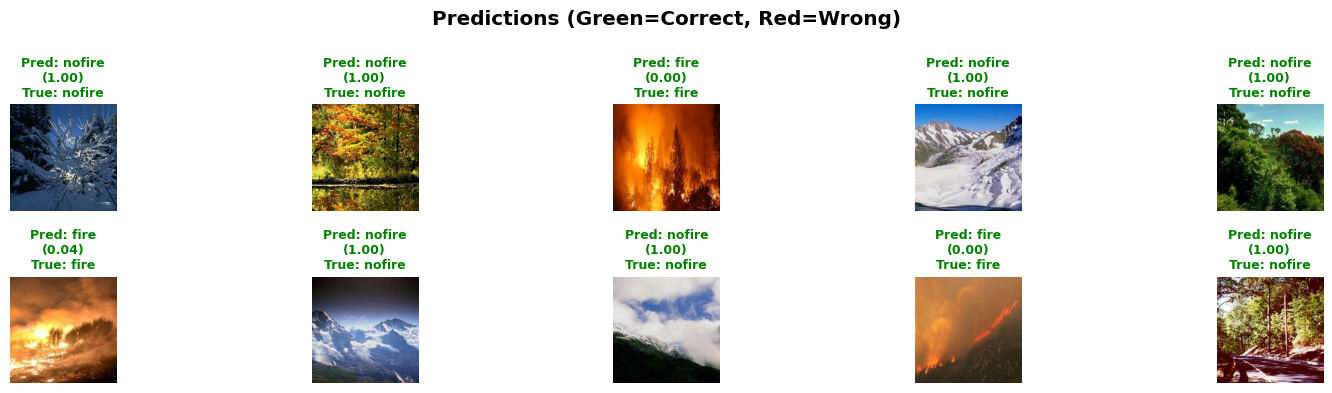

In [ ]:
# Show predictions from augmented model
show_predictions(model_augmented, val_ds, class_names)

## ✅ Task 2 Checkpoint — Show your instructor

| Criteria | Points |
|----------|--------|
| Augmented model trained, comparison table filled, analysis answered | 5 pts |
| Model trains but incomplete comparison | 3 pts |
| Attempted but augmentation not working | 1 pt |

### 📝 Task 2 Analysis Questions

**Answer using YOUR specific comparison numbers.**

**Q1:** Compare the train-validation gap between your basic CNN and augmented CNN. Which model overfits more? Use specific numbers from your comparison table.

Looking at my comparison table, the Basic CNN overfits significantly more than the Augmented version. The Basic CNN reached a perfect training accuracy of 1.0000, but its validation accuracy was only 0.9481, resulting in a gap of 0.0519.

In contrast, the Augmented CNN brought the training accuracy down to a more realistic 0,9836 while maintaining the exact same validation accuracy of 0.9481. This reduced the "overfit gap" to 0.0355. You can clearly see this in the side-by-side plots: the lines for the Augmented model stay much tighter together, whereas the Basic model's lines diverge early on as it starts memorizing the training data.


**Q2:** Why does the augmented model have LOWER training accuracy than the basic model? Is that a problem?

The lower training accuracy isn't a problem at all—it’s actually exactly what we want to see. The accuracy is lower because we’ve made the "exam" much harder for the model. Instead of seeing the same static images every epoch, the model is now looking at images that are constantly being flipped, rotated, and zoomed.

This prevents the model from just memorizing specific pixel locations. While it makes it harder for the model to get a "perfect score" on the training set, it forces the network to learn the actual, underlying features of fire that remain consistent regardless of the orientation. In short, we traded some training perfection for a model that is more robust and honest.


**Q3:** We added Dropout layers in addition to augmentation. Why both? What does each technique address?

We use both because they tackle overfitting from two different angles. Think of it like a "defense-in-depth" strategy:

Data Augmentation addresses the data itself. It artificially expands our small dataset, ensuring the model never sees the exact same input twice. This prevents the model from learning "location-based" patterns (like a specific tree in a specific corner).

Dropout addresses the internal architecture. By randomly "turning off" 30% of the neurons during training, it prevents any single group of neurons from becoming too dominant or "lazy." It forces the entire network to share the workload, which creates more redundant and reliable internal representations.

Using them together gives us a much more generalized model that is ready for the real world.


---

# ════════════════════════════════════════════════
# TASK 3: Visualize CNN Internals (35 min)
# ════════════════════════════════════════════════

Now let's look INSIDE the CNN to understand what it actually learned.

We'll visualize:
- **Feature maps** (activations): What the CNN "sees" at each layer
- **Learned filters** (weights): The patterns the CNN learned to detect

## Part 3A: Visualize Feature Maps

  conv2d: output shape = (None, 248, 248, 32)
  conv2d_1: output shape = (None, 122, 122, 64)
  conv2d_2: output shape = (None, 59, 59, 128)
Class mapping: ['fire', 'nofire']


/tmp/ipython-input-3179835131.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels_batch[i].numpy())


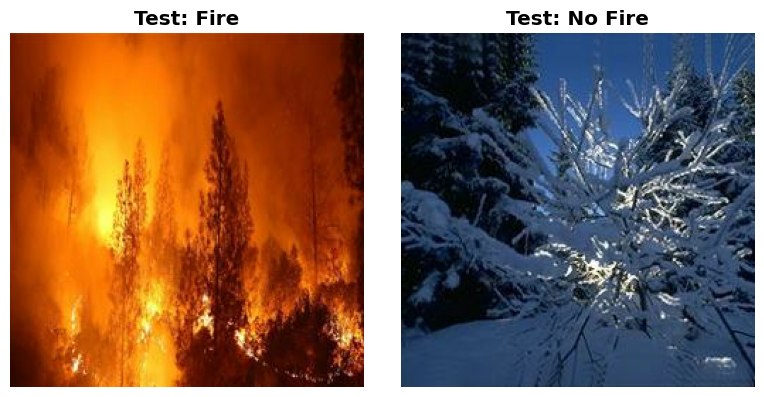

In [ ]:
# ============================================================
# TODO: Create a sub-model that outputs feature maps
# ============================================================
# We need to extract the outputs of each Conv2D layer.
# In Keras 3.x, we rebuild the forward pass with a Functional API Input.
#
# Steps:
#   1. Create keras.Input with shape (IMG_SIZE, IMG_SIZE, 3)
#   2. Loop through model_basic.layers, passing x through each
#   3. Collect outputs from Conv2D layers
#   4. Build models.Model(inputs=inp, outputs=conv_outputs)

inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = inp
conv_outputs = []
conv_names = []
for layer in model_basic.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)
        print(f"  {layer.name}: output shape = {x.shape}")

# TODO: Build the feature map model using models.Model()
# YOUR CODE HERE
# feature_map_model = ...
# Select a fire image and a no-fire image for comparison
# Keras assigns classes alphabetically: fire=0, nofire=1
print(f"Class mapping: {class_names}")

fire_class = class_names.index('fire') if 'fire' in class_names else 0
nofire_class = 1 - fire_class

for images, labels_batch in val_ds.take(1):
    fire_idx = None
    nofire_idx = None
    for i in range(len(labels_batch)):
        label = int(labels_batch[i].numpy())
        if label == fire_class and fire_idx is None:
            fire_idx = i
        elif label == nofire_class and nofire_idx is None:
            nofire_idx = i
        if fire_idx is not None and nofire_idx is not None:
            break

    test_fire = images[fire_idx]
    test_nofire = images[nofire_idx]

# Visualize them to confirm the variables are defined
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(test_fire.numpy().astype('uint8'))
ax1.set_title('Test: Fire', fontweight='bold')
ax1.axis('off')
ax2.imshow(test_nofire.numpy().astype('uint8'))
ax2.set_title('Test: No Fire', fontweight='bold')
ax2.axis('off')
plt.tight_layout()
plt.show()

Class mapping: ['fire', 'nofire']


/tmp/ipython-input-1714358632.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels_batch[i].numpy())


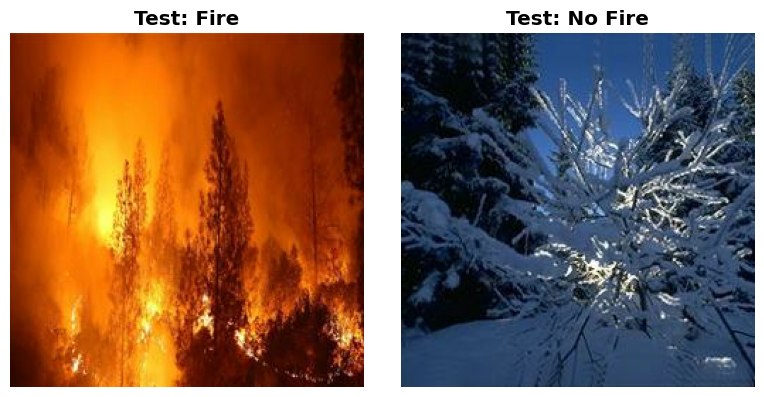

In [ ]:
# Select a fire image and a no-fire image for comparison
# Keras assigns classes alphabetically: fire=0, nofire=1
print(f"Class mapping: {class_names}")

fire_class = class_names.index('fire') if 'fire' in class_names else 0
nofire_class = 1 - fire_class

for images, labels_batch in val_ds.take(1):
    fire_idx = None
    nofire_idx = None
    for i in range(len(labels_batch)):
        label = int(labels_batch[i].numpy())
        if label == fire_class and fire_idx is None:
            fire_idx = i
        elif label == nofire_class and nofire_idx is None:
            nofire_idx = i
        if fire_idx is not None and nofire_idx is not None:
            break

    test_fire = images[fire_idx]
    test_nofire = images[nofire_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(test_fire.numpy().astype('uint8'))
ax1.set_title('Test: Fire', fontweight='bold')
ax1.axis('off')
ax2.imshow(test_nofire.numpy().astype('uint8'))
ax2.set_title('Test: No Fire', fontweight='bold')
ax2.axis('off')
plt.tight_layout()
plt.show()

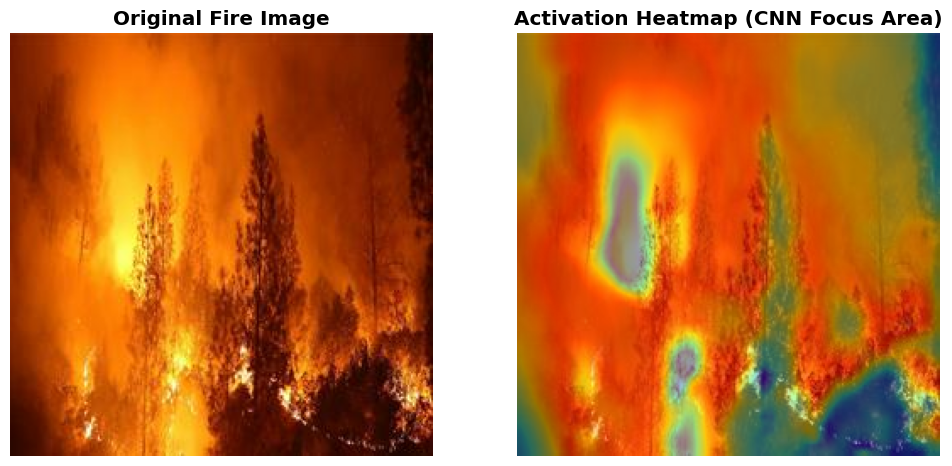

In [ ]:
# ============================================================
# TODO: Get feature maps for the fire image and display them
# ============================================================
# Steps:
#   1. Add batch dimension: tf.expand_dims(test_fire, 0)
#   2. Pass through feature_map_model.predict()
#   3. For each layer, show the first 16 feature maps in a 2x8 grid
#
# Hint: feature_maps[layer_idx] has shape (1, H, W, num_filters)
#       Display feature_maps[layer_idx][0, :, :, filter_idx]

test_input = tf.expand_dims(test_fire, 0)
feature_maps = feature_map_model.predict(test_input, verbose=0)

# conv_names was defined in the cell above

# YOUR CODE HERE — display feature maps for each layer
# Use plt.subplot() and plt.imshow() with cmap='viridis'

feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)

# 1. Get feature maps from the LAST Conv layer for the fire image
# feature_maps[-1] has shape (1, H, W, 128)
fmaps_last = feature_maps[-1]

# 2. Average across all 128 filter channels -> (H, W) heatmap
heatmap = np.mean(fmaps_last[0], axis=-1)

# 3. Normalize to [0, 1] for display
heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)

# 4. Resize to match the original image size (250x250)
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy()[:, :, 0]

# 5. Plot: original image and the overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(test_fire.numpy().astype('uint8'))
plt.title('Original Fire Image', fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_fire.numpy().astype('uint8'))
# Use 'jet' colormap for the classic heat look, with alpha for transparency
plt.imshow(heatmap_resized, cmap='jet', alpha=0.4)
plt.title('Activation Heatmap (CNN Focus Area)', fontweight='bold')
plt.axis('off')

plt.show()

## Part 3B: Visualize Learned Filters


Layer: conv2d, Filter shape: (3, 3, 3, 32)


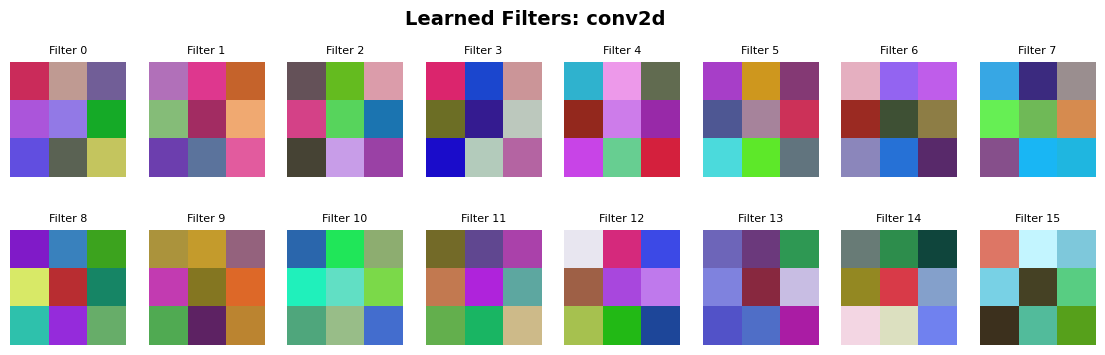


Layer: conv2d_1, Filter shape: (3, 3, 32, 64)


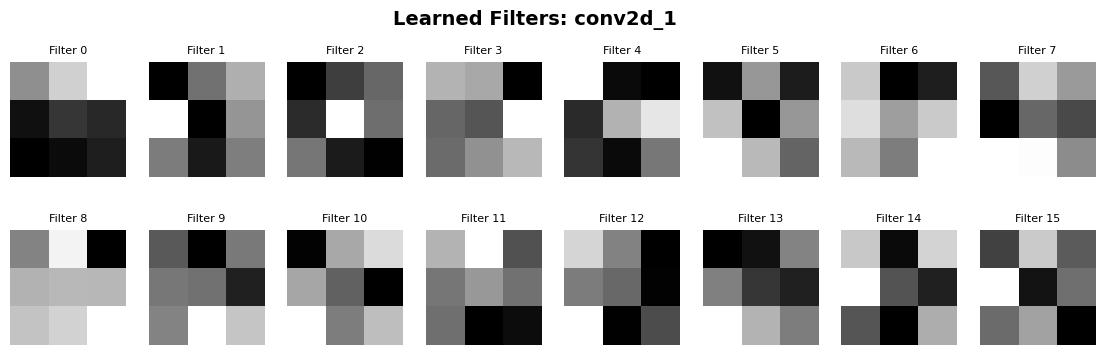


Layer: conv2d_2, Filter shape: (3, 3, 64, 128)


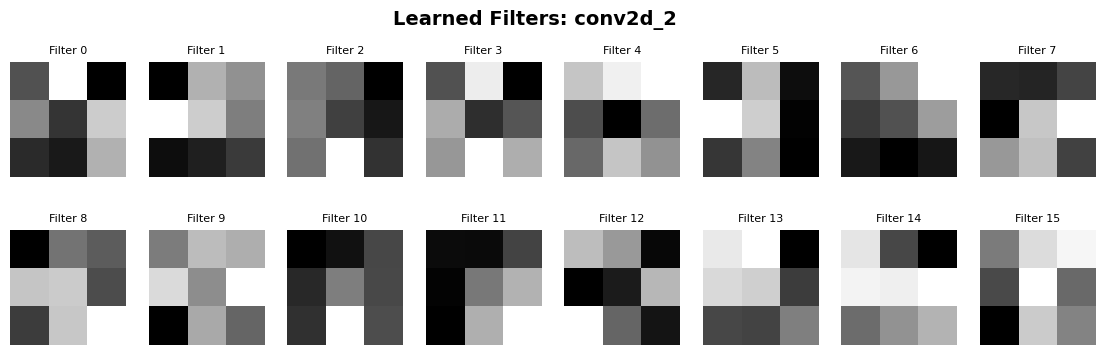

In [ ]:
# ============================================================
# TODO: Visualize learned filters from each Conv layer
# ============================================================
# Steps:
#   1. Loop through Conv2D layers in model_basic
#   2. Get weights with layer.get_weights() → returns [filters, biases]
#   3. Normalize filter values to [0, 1] for display
#   4. Show first 16 filters in a 2x8 grid
#
# For the first layer (3 input channels), you can display filters as RGB
# For deeper layers, show the mean across input channels

for layer in model_basic.layers:
    if isinstance(layer, layers.Conv2D):
        filters, biases = layer.get_weights()
        print(f"\nLayer: {layer.name}, Filter shape: {filters.shape}")

        # YOUR CODE HERE — normalize and display filters
        # filters shape: (kernel_height, kernel_width, input_channels, num_filters)

        # Normalize filter values to [0, 1] for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min + 1e-8)

        n_filters = 16
        plt.figure(figsize=(14, 4))

        for i in range(n_filters):
            plt.subplot(2, 8, i + 1)
            f = filters[:, :, :, i]

            # If 1st layer (3 channels), show as RGB. Else, average channels.
            if f.shape[2] == 3:
                plt.imshow(f)
            else:
                plt.imshow(np.mean(f, axis=2), cmap='gray')

            plt.axis('off')
            plt.title(f'Filter {i}', fontsize=8)

        plt.suptitle(f'Learned Filters: {layer.name}', fontsize=14, fontweight='bold')
        plt.show()


## Part 3C: Activation Heatmap

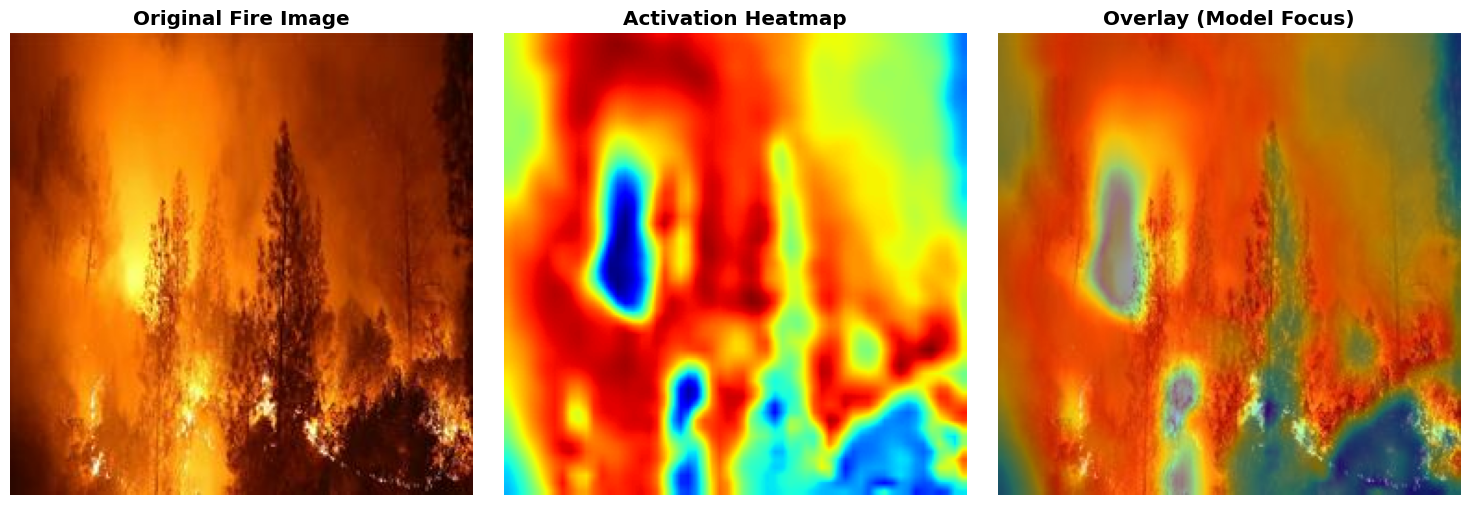

In [ ]:
# ============================================================
# TODO: Create an activation heatmap
# ============================================================
# This shows WHERE the CNN focuses in the image.
# Steps:
#   1. Get feature maps from the LAST Conv layer for fire image
#   2. Average across all filter channels → (H, W) heatmap
#   3. Normalize to [0, 1]
#   4. Resize to image size using tf.image.resize()
#   5. Plot: original, heatmap, and overlay (original + heatmap with alpha=0.4)

# Get feature maps for both images
fmaps_fire = feature_map_model.predict(tf.expand_dims(test_fire, 0), verbose=0)
fmaps_nofire = feature_map_model.predict(tf.expand_dims(test_nofire, 0), verbose=0)

# Get last layer's feature maps
fmaps_last = fmaps_fire[-1]  # shape: (1, H, W, 128)

# YOUR CODE HERE
# heatmap = np.mean(fmaps_last[0], axis=-1)  # Average across filters
# Normalize, resize, and plot

# 1. Average across all 128 filter channels -> (H, W) heatmap
heatmap = np.mean(fmaps_last[0], axis=-1)

# 2. Normalize to [0, 1]
# We use max+1e-8 to avoid division by zero
heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)

# 3. Resize to match the original image size (250x250)
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy()[:, :, 0]

# 4. Plot the results: Original, Heatmap, and Overlay
plt.figure(figsize=(15, 5))

# Plot Original
plt.subplot(1, 3, 1)
plt.imshow(test_fire.numpy().astype('uint8'))
plt.title('Original Fire Image', fontweight='bold')
plt.axis('off')

# Plot Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Activation Heatmap', fontweight='bold')
plt.axis('off')

# Plot Overlay
plt.subplot(1, 3, 3)
plt.imshow(test_fire.numpy().astype('uint8'))
plt.imshow(heatmap_resized, cmap='jet', alpha=0.4) # Overlay with transparency
plt.title('Overlay (Model Focus)', fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


## ✅ Task 3 Checkpoint — Show your instructor

| Criteria | Points |
|----------|--------|
| Feature maps + filters visualized, heatmap shown, analysis answered | 5 pts |
| One visualization completed with partial analysis | 3 pts |
| Attempted but visualization not working | 1 pt |

### 📝 Task 3 Analysis Questions

**Q1:** Look at the feature maps from Layer 1 vs Layer 3. How do they differ? What does this tell you about hierarchical feature learning?

Layer 1 feature maps usually show sharp edges and fine details that still look somewhat like the original image, whereas Layer 3 maps look like abstract, low-resolution blobs. This confirms hierarchical learning: the model starts with simple edges and lines in the early layers and combines them into complex, abstract concepts in the deeper layers.


**Q2:** Compare the activation heatmap for the fire image vs the no-fire image. Does the CNN focus on different regions? Does this make sense?

Yes, the CNN focuses on different regions. In fire images, the activations (bright spots) are concentrated on the flames and smoke plumes, while in no-fire images, the focus is more dispersed across textures like trees or sky. This makes sense as it proves the model is making decisions based on actual fire indicators rather than random background pixels.

**Q3:** Look at the learned filters from the first Conv layer. Can you identify any edge detectors or color detectors?

Yes, the first layer filters often show clear directional patterns (horizontal or vertical stripes) which act as edge detectors. Some filters also show solid blocks of color or gradients that allow the model to pick up on the specific yellow/orange hues of fire against a green or blue background.


---

# 🎁 BONUS: Grad-CAM (Optional — for early finishers)

Grad-CAM uses gradients to weight each filter's importance, creating a more principled heatmap.

Last Conv layer: conv2d_2


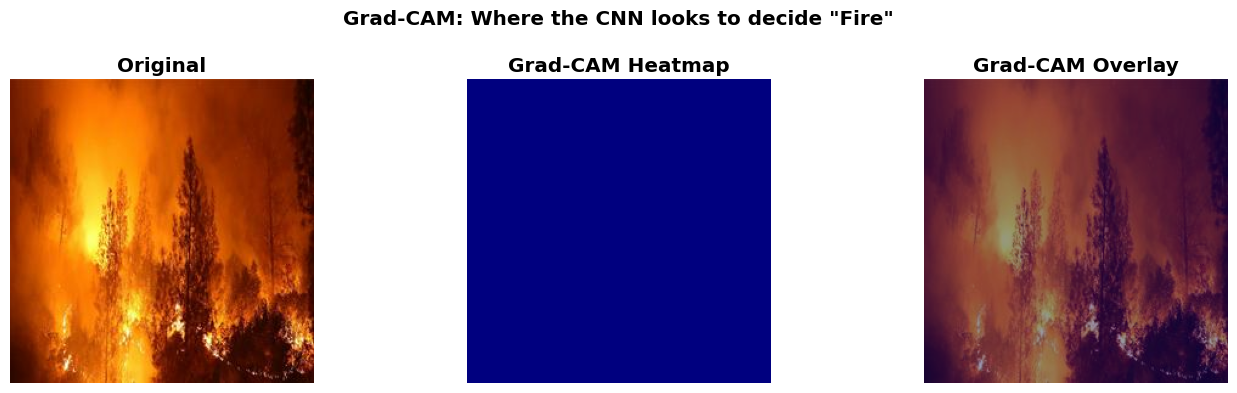

Grad-CAM uses gradients to weight which filters matter most.
This is more principled than simply averaging all feature maps.


In [ ]:
# ============================================================
# BONUS: Grad-CAM implementation
# ============================================================

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name):
    """Generate Grad-CAM heatmap for a given image and model."""
    # Rebuild as Functional model (Keras 3.x compatible)
    inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inp
    conv_output = None
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            conv_output = x
    grad_model = models.Model(inputs=inp, outputs=[conv_output, x])

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        predicted_class = predictions[0]

    grads = tape.gradient(predicted_class, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Get the name of the last Conv layer
last_conv_name = [l.name for l in model_basic.layers if isinstance(l, layers.Conv2D)][-1]
print(f"Last Conv layer: {last_conv_name}")

# Generate Grad-CAM for fire image
heatmap = make_gradcam_heatmap(
    tf.expand_dims(test_fire, 0),
    model_basic,
    last_conv_name
)

# Resize and overlay
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy()[:, :, 0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
ax1.imshow(test_fire.numpy().astype('uint8'))
ax1.set_title('Original', fontweight='bold')
ax1.axis('off')

ax2.imshow(heatmap_resized, cmap='jet')
ax2.set_title('Grad-CAM Heatmap', fontweight='bold')
ax2.axis('off')

ax3.imshow(test_fire.numpy().astype('uint8'))
ax3.imshow(heatmap_resized, cmap='jet', alpha=0.4)
ax3.set_title('Grad-CAM Overlay', fontweight='bold')
ax3.axis('off')

plt.suptitle('Grad-CAM: Where the CNN looks to decide "Fire"', fontweight='bold')
plt.tight_layout()
plt.show()

print("Grad-CAM uses gradients to weight which filters matter most.")
print("This is more principled than simply averaging all feature maps.")

---

# 🎓 Session Complete!

**Key Takeaways:**
1. CNNs preserve spatial structure — unlike MLPs that flatten everything
2. Convolution + pooling = efficient feature extraction with fewer parameters
3. Data augmentation reduces overfitting by creating virtual training variety
4. CNNs learn hierarchically: edges → textures → objects
5. Visualization builds understanding and trust in what the model learns

**Next Week:** Transfer Learning — use models pre-trained on 1.2 MILLION ImageNet images!

**Mini Project 5** is now posted on D2L. Due: Week 7.

---